# makemore: part 3


In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

%matplotlib inline
device = "cuda"

# reproducibility
random.seed(42)
g = torch.Generator(device=device).manual_seed(42)
device

'cuda'

In [2]:
# read in all the words
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# context length: how many characters do we take to predict the next one?
block_size = 3


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X, device=device)
    Y = torch.tensor(Y, device=device)
    print(X.shape, Y.shape)
    return X, Y


random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])  # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g, device=device) / fan_in**0.5
        self.bias = torch.zeros(fan_out, device=device) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim, device=device)
        self.beta = torch.zeros(dim, device=device)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim, device=device)
        self.running_var = torch.ones(dim, device=device)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)  # batch mean
            xvar = x.var(0, keepdim=True)  # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


n_embd = 16  # the dimensionality of the character embedding vectors
n_hidden = 256  # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size, n_embd), generator=g, device=device)
layers = [
    # block 1
    Linear(n_embd * block_size, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    # layer 2
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    # layer 3 (output)
    Linear(n_hidden, vocab_size, bias=False),
    BatchNorm1d(vocab_size),
]

with torch.no_grad():
    for layer in layers:
        if isinstance(layer, Linear):
            layer.weight *= 5 / 3
    layers[-1].gamma *= 0.1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

86246


In [7]:
# same optimization as last time
max_steps = 5000
batch_size = 2**14
lossi = []
ud = []
bn_bias = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g, device=device)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 500 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        eps = 1e-12
        ud.append([((lr * p.grad).std() / (p.data.std() + eps)).log10().item() for p in parameters])
        bn_bias.append(layers[-1].beta.detach().cpu().clone())

      0/   5000: 3.3113
    500/   5000: 2.4946
   1000/   5000: 2.3011
   1500/   5000: 2.2024
   2000/   5000: 2.1839
   2500/   5000: 2.1385
   3000/   5000: 2.1226
   3500/   5000: 2.1000
   4000/   5000: 2.1096
   4500/   5000: 2.0646


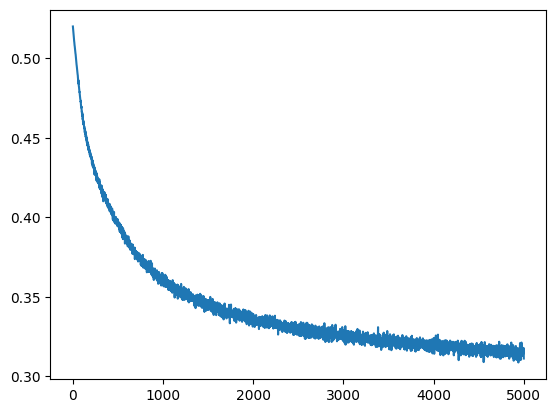

In [8]:
plt.plot(lossi)

In [9]:
@torch.no_grad()
def split_loss(split, layers=layers):
    X, Y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    emb = C[X]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Y)
    print(split, loss.item())


# put layers into eval mode
for layer in layers:
    layer.training = False
split_loss("train")
split_loss("val")

train 2.066154718399048
val 2.124772310256958


In [16]:
@torch.no_grad()
def fold_linear_bn(linear: Linear, bn: BatchNorm1d) -> Linear:
    """Fuses a linear layer and a batch normalization layer into a single linear layer.

    Linear layer does for given x, return x @ W + b
    BatchNorm1d does for given x, return gamma * (x - running_mean) / sqrt(running_var + eps)) + beta

    We want to get linear layer that does both of these two things.
    Let output of linear layer be y = x @ W + b
    Let output of batchnorm be z = gamma * (z - running_mean) / sqrt(running_var + eps)) + beta
    Then z = gamma * (x @ W + b - running_mean) / sqrt(running_var + eps) + beta
    Let C = gamma / sqrt(running_var + eps)
    Then z = C * (x @ W) + C * (b - running_mean) + beta

    weights = C * W
    bias = C * (b - running_mean) + beta)
    """
    running_mean = bn.running_mean.view(-1)
    running_var = bn.running_var.view(-1)
    gamma = bn.gamma.view(-1)
    beta = bn.beta.view(-1)
    eps = bn.eps

    if linear.bias is None:
        b = torch.zeros_like(beta)
    else:
        b = linear.bias

    C = gamma / torch.sqrt(running_var + eps)

    fused = Linear(linear.weight.shape[0], linear.weight.shape[1], bias=True)
    fused.weight = linear.weight * C
    fused.bias = (b - running_mean) * C + beta
    return fused


layers_fused = [
    fold_linear_bn(layers[0], layers[1]),
    layers[2],
    fold_linear_bn(layers[3], layers[4]),
    layers[5],
    fold_linear_bn(layers[6], layers[7]),
]

split_loss("train", layers_fused)
split_loss("val", layers_fused)


train 2.066154718399048
val 2.124772310256958
